In [29]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import statistics
import random
import warnings
import sys

warnings.filterwarnings('ignore')

from plotting import *

from utils.preprocessing import load_data,center_data
from utils.plotting import plot_single, plot_setup, get_smoothed

In [30]:
df = load_data('./data/Geo_Mag_Vari_Odessa_25-31_Jan_2018.txt')
df['y_centered'] = center_data(df.By)
my_func = 'Geo_Mag_Vari_Odessa_25-31_Jan_2018.txt'
dom = df.Time.to_numpy()
y_label = 'Bx'
vals = df[y_label].to_numpy()

myfigsize = (14,4)

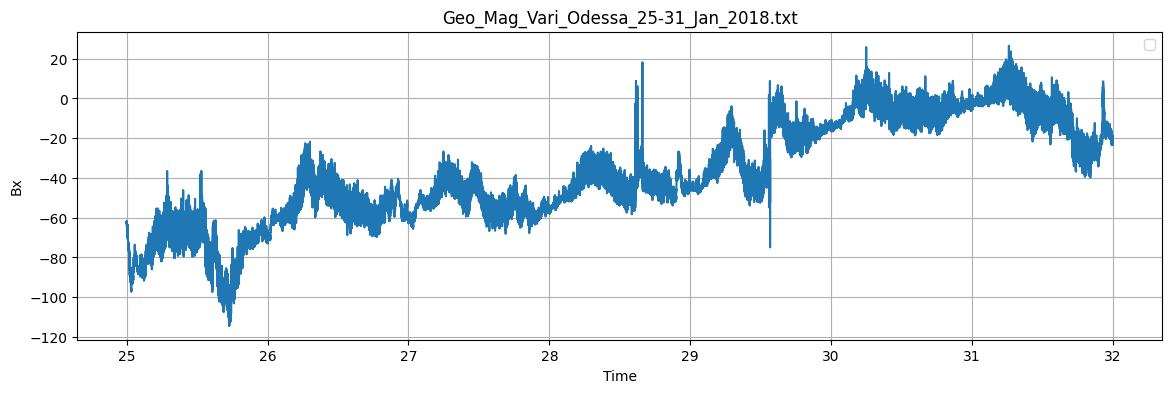

In [31]:
plt.figure(figsize=myfigsize)
plt.plot(dom, vals)
plot_setup(title=my_func, ylabel=y_label)

In [32]:
# arr = np.arange(100,200)
# dom = np.arange(0,100)
# train_t, test_t, train_x, test_x = train_test_split(dom, arr, shuffle=False, test_size=0.25)
# print(train_t)
# print(test_t)
# print(train_x)
# print(test_x)

In [33]:
# plt.figure(figsize=(12,4))
# plt.plot(train_t, train_x, label='train')
# plt.plot(test_t, test_x, label='test')
# plot_setup(title=my_func, ylabel=y_label)

In [34]:
# dom.shape[0] / period

In [35]:
test_periods = 2
train_t, test_t, train_x, test_x = train_test_split(dom, vals, shuffle=False, test_size=test_periods/7)

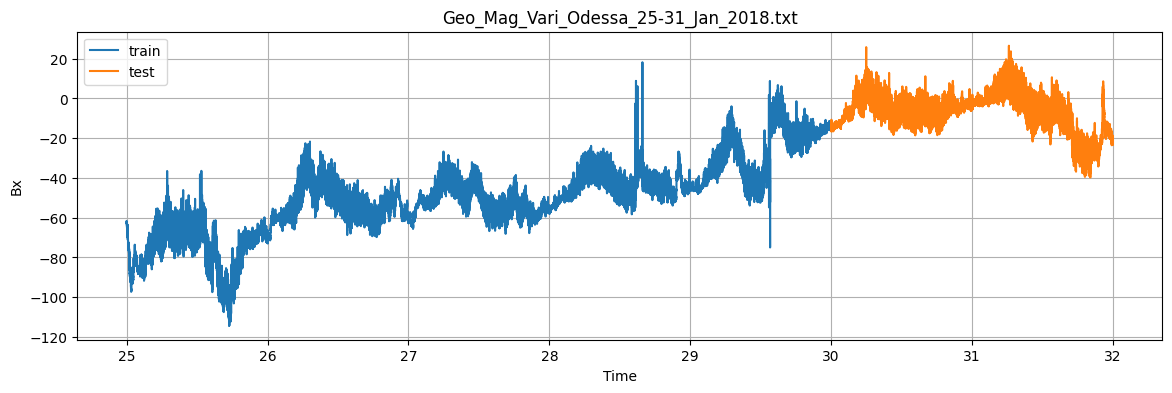

In [36]:
plt.figure(figsize=myfigsize)
plt.plot(train_t, train_x, label='train')
plt.plot(test_t, test_x, label='test')
plot_setup(title=my_func, ylabel=y_label)

#TODO
add trend detection tests

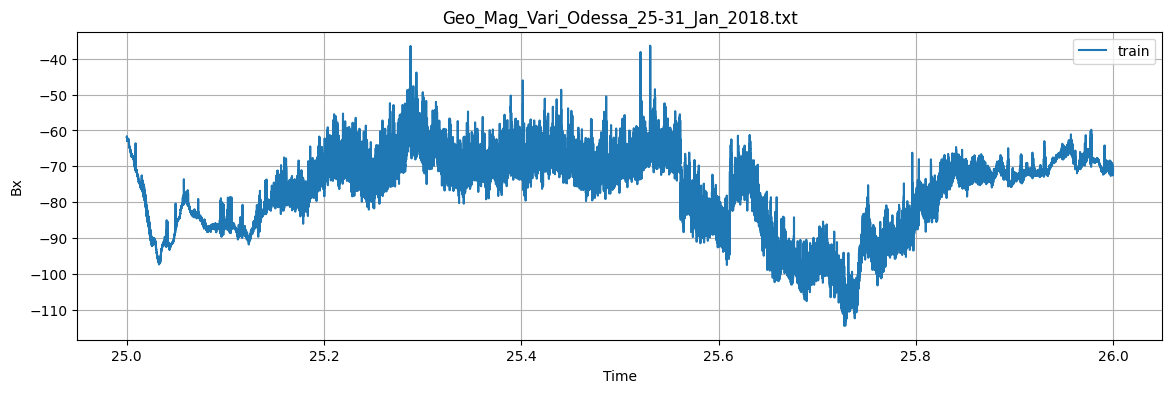

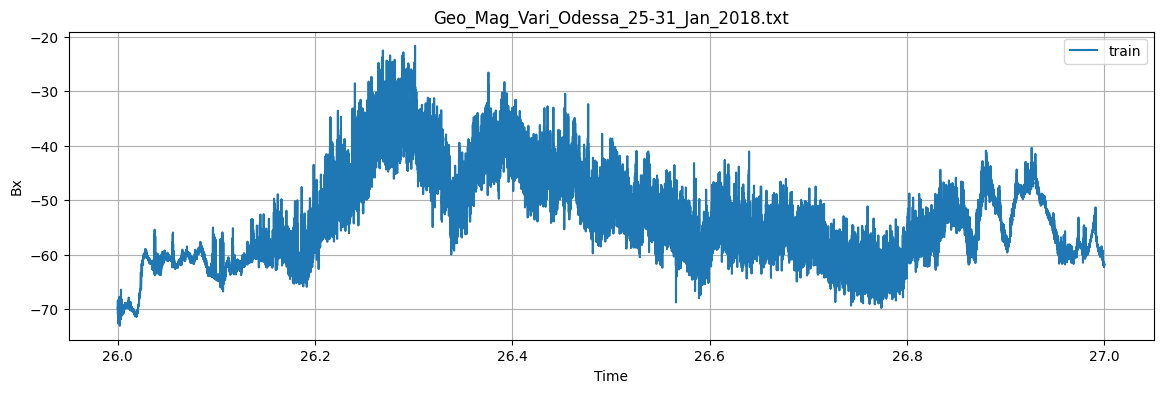

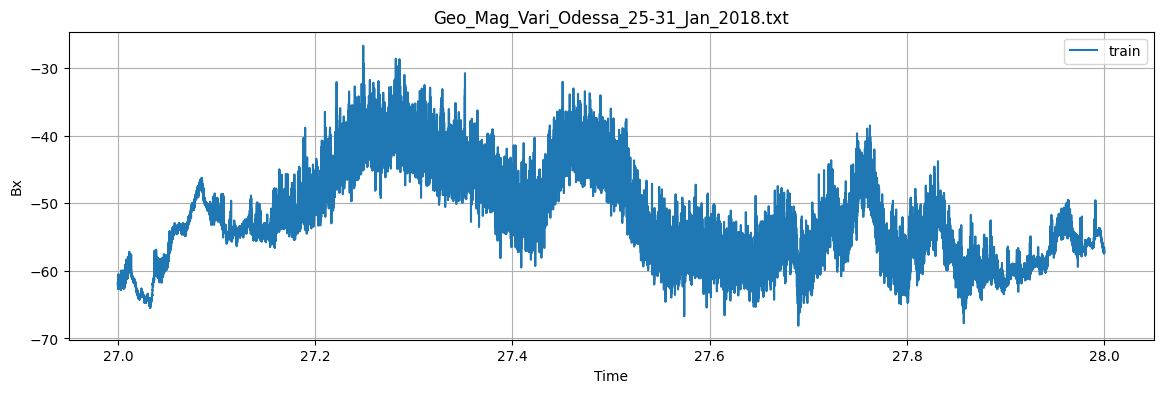

In [37]:
for i in range(3):
    plt.figure(figsize=myfigsize)
    start = 86400 * i
    interval = 86400
    plt.plot(train_t[start:start+interval], train_x[start:start+interval], label='train')
    plot_setup(title=my_func, ylabel=y_label)

In [38]:
period = 86400

In [39]:
structured_data = train_x.reshape(len(train_x) // period, -1)
structured_data.shape

(5, 86400)

In [40]:
periodic_running_mean = get_smoothed(train_x, period)[period // 2 : -( (period - 1) // 2)]
centered_running_mean = (periodic_running_mean[1:] + periodic_running_mean[:-1]) / 2
print((periodic_running_mean).shape)
print(centered_running_mean.shape)
print(f'{train_x.shape = }')

seasonal_eval = train_x[period//2:-period//2] - centered_running_mean
print(f'{seasonal_eval.shape = }')
print(f'{seasonal_eval = }')

(345601,)
(345600,)
train_x.shape = (432000,)
seasonal_eval.shape = (345600,)
seasonal_eval = array([ 11.43448131,   9.82457112,   9.81465457, ..., -10.33305787,
       -11.05340388,  -9.45374873])


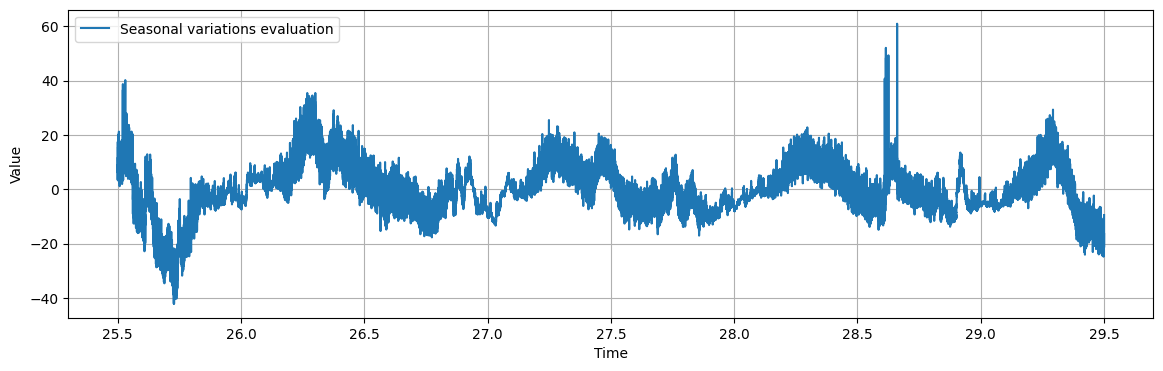

In [41]:
plt.figure(figsize=myfigsize) 
plt.plot(train_t[period//2:-period//2], seasonal_eval, label='Seasonal variations evaluation')
plot_setup()

In [42]:
mean_per_point = seasonal_eval.reshape(-1, period).mean(axis=0)
print(mean_per_point)
arr_скореговані_сезонні_компоненти = mean_per_point - mean_per_point.mean()
print(f'{arr_скореговані_сезонні_компоненти = }')
print(f'Something that must be 0: {np.round(arr_скореговані_сезонні_компоненти.mean(), 2) = }')

[ 3.8004958   2.8404479   3.37040012 ... -1.7061661  -1.43382826
 -0.55148903]
arr_скореговані_сезонні_компоненти = array([ 4.59731224,  3.63726433,  4.16721655, ..., -0.90934967,
       -0.63701182,  0.2453274 ])
Something that must be 0: np.round(arr_скореговані_сезонні_компоненти.mean(), 2) = 0.0


In [43]:
idx = period // 2
arr_скореговані_сезонні_компоненти = np.concatenate((arr_скореговані_сезонні_компоненти[idx:], arr_скореговані_сезонні_компоненти[:idx]))
Seзонні_компоненти = np.repeat(arr_скореговані_сезонні_компоненти.reshape(1,-1), len(train_x) // period, axis=0).ravel()

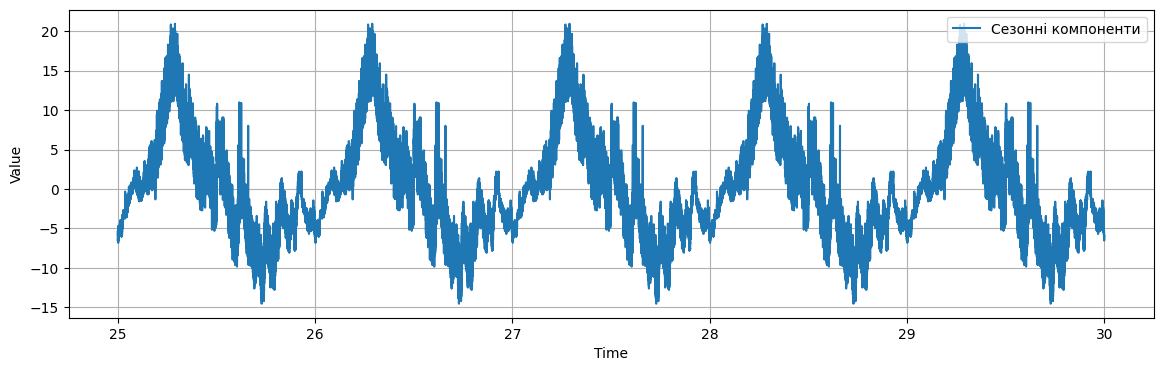

In [44]:
# plt.figure(figsize=myfigsize) 
# plt.plot(train_t[period//2:-period//2], seasonal_eval, label='S')
# plot_setup()
plt.figure(figsize=myfigsize) 
plt.plot(train_t, Seзонні_компоненти, label='Ceзонні компоненти')
plot_setup()

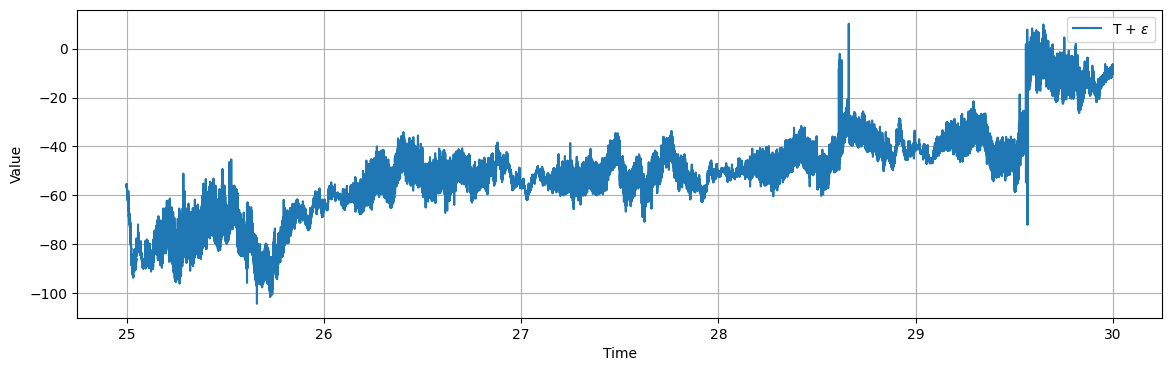

In [45]:
TplusE = train_x - Seзонні_компоненти
plt.figure(figsize=myfigsize) 
plt.plot(train_t, TplusE, label=f'T + $\\varepsilon$')
plot_setup()

In [46]:
def get_coeffs(y, df):
    beta = np.linalg.inv(df.T @ df) @ df.T @ y
    return beta

def get_preds(df, beta):
    beta = np.array(beta)
    preds = df @ beta
    return preds

In [47]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train_t.reshape(-1, 1), TplusE)

K = model.coef_.item()
b = model.intercept_.item()
print(f'{np.round(K, 3) = }')
print(f'b = {np.round(b, 3)}')

np.round(K, 3) = 11.012
b = -353.752


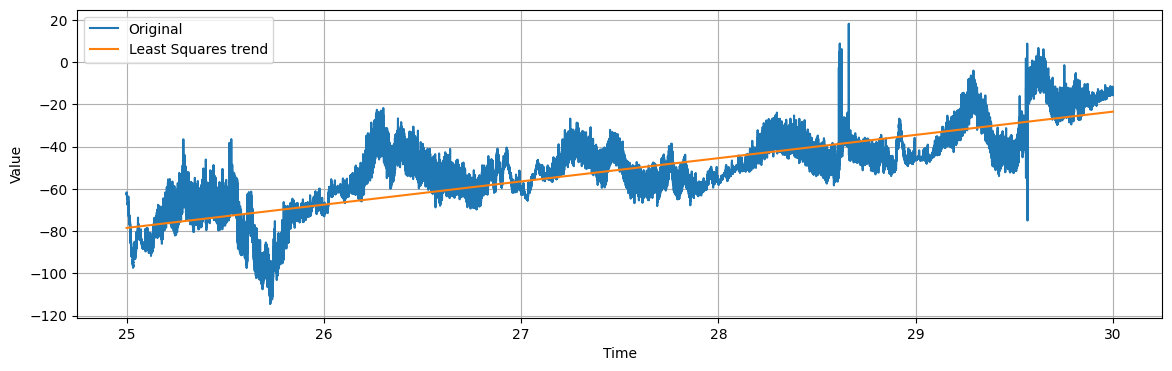

In [48]:
def LSQR(x, k=K, b=b): 
    return k*x + b 

plt.figure(figsize=myfigsize)
plt.plot(train_t, train_x, label='Original')
plt.plot(train_t, LSQR(train_t), label='Least Squares trend')
plot_setup()

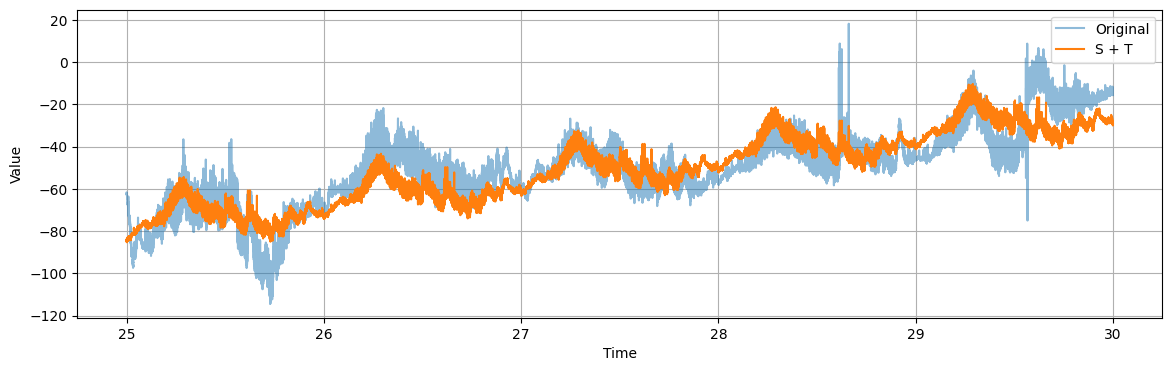

In [49]:
plt.figure(figsize=myfigsize) 
plt.plot(train_t, train_x, alpha=0.5, label='Original')
plt.plot(train_t, LSQR(train_t) + Seзонні_компоненти, label='S + T')
plot_setup()

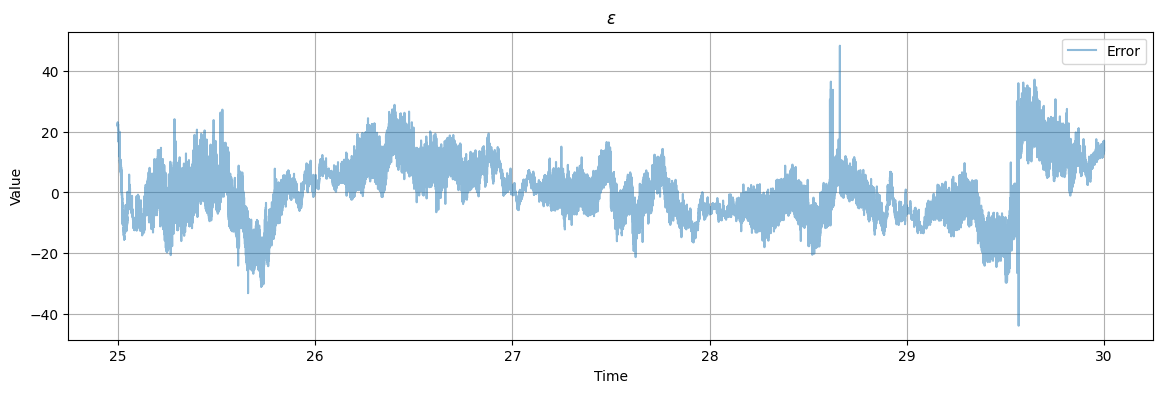

In [50]:
epses = train_x - (LSQR(train_t) + Seзонні_компоненти)
plt.figure(figsize=myfigsize)
plt.plot(train_t, epses, alpha=0.5, label='Error')
plot_setup(title='$\\varepsilon$')

#TODO
проверка на адекватность

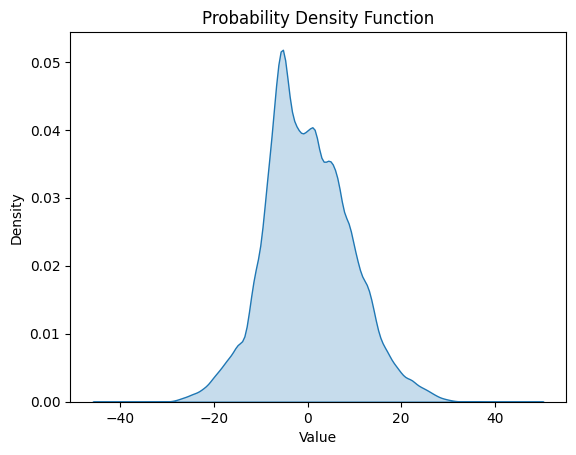

In [51]:
sns.kdeplot(epses, fill=True)
plt.title("Probability Density Function")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

In [52]:
def get_evals(y, pred, N, alpha=0.2):
    disp = np.sum((y - pred)**2) / (len(y) - N)
    MSE = np.sum((y - pred)**2) / (len(y))
    MAPE = np.sum(np.abs(y - pred) / y) / len(y)
    mat = np.sum(y - pred) / len(y)
    print(f'{disp=}, {MSE=}, {MAPE=}, {mat=}')

In [53]:
get_evals(train_x, Seзонні_компоненти + LSQR(train_t), N=0)

disp=81.89514986093377, MSE=81.89514986093377, MAPE=inf, mat=3.206810948473436e-14


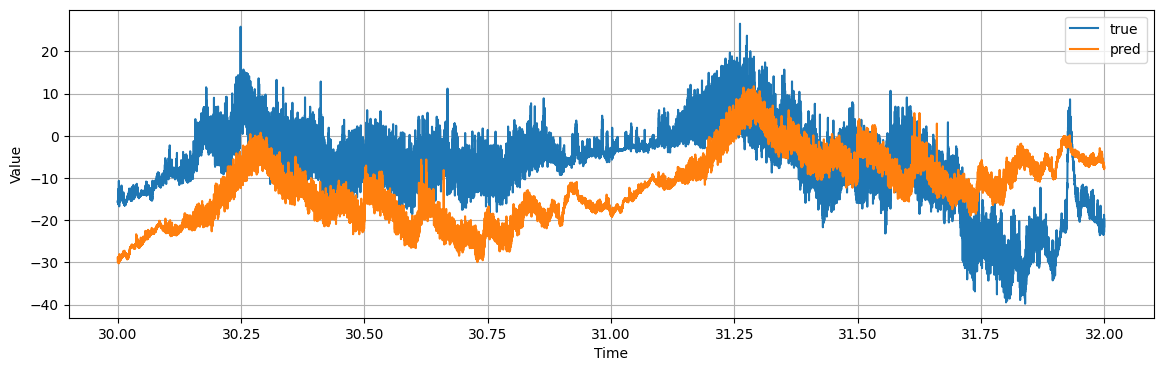

In [56]:
predictions = Seзонні_компоненти[:test_t.shape[0]] + LSQR(test_t)
plt.figure(figsize=myfigsize)
plt.plot(test_t, test_x, label='true')
plt.plot(test_t, predictions, label='pred')
plot_setup()

In [57]:
get_evals(test_x, predictions, N=0)

disp=141.87400960396292, MSE=141.87400960396292, MAPE=inf, mat=4.857777145475437
